## Missile Guidance Simulation Setup

In [92]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

## Plotting Nσ(μ), Nγ(μ), and Their Ratio

This cell defines and plots the functions:

- **Nσ(μ)** and **Nγ(μ)**: Key functions dependent on the homing guidance parameter μ, used in optimal guidance formulations.
- μ values are carefully filtered to avoid singularities in the denominator.
- Three plots are generated:
  - Nσ(μ) vs μ
  - Nγ(μ) vs μ
  - Nσ(μ)/Nγ(μ) vs μ

These plots help visualize the behavior of guidance gains and their ratio across different μ values.


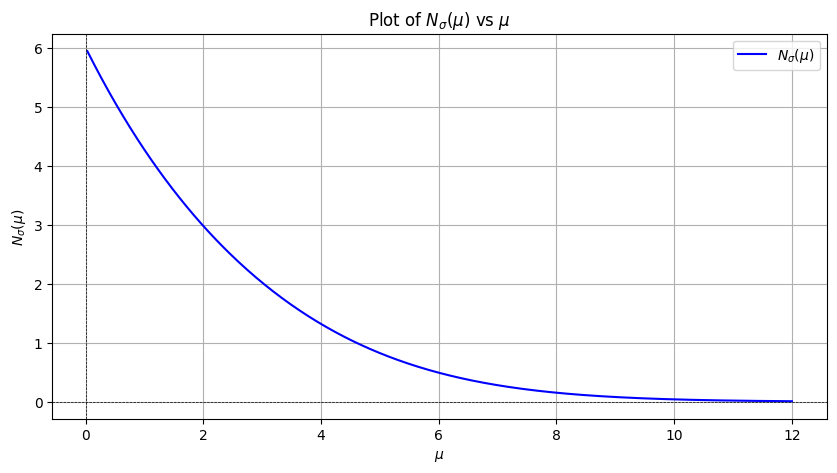

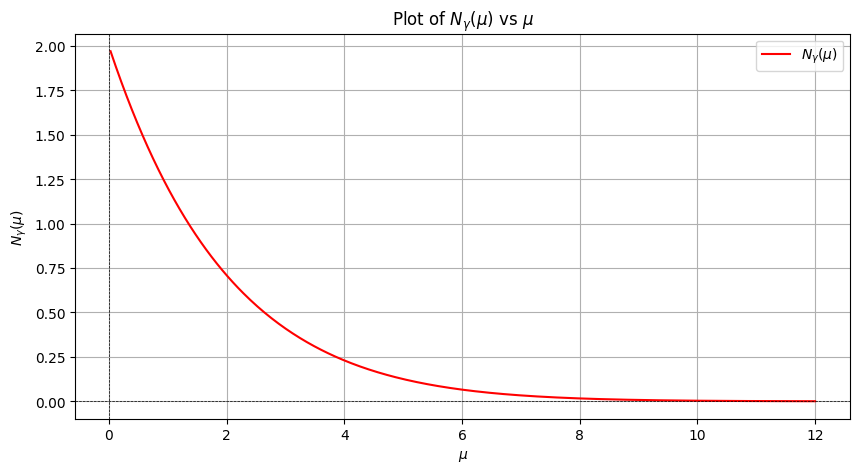

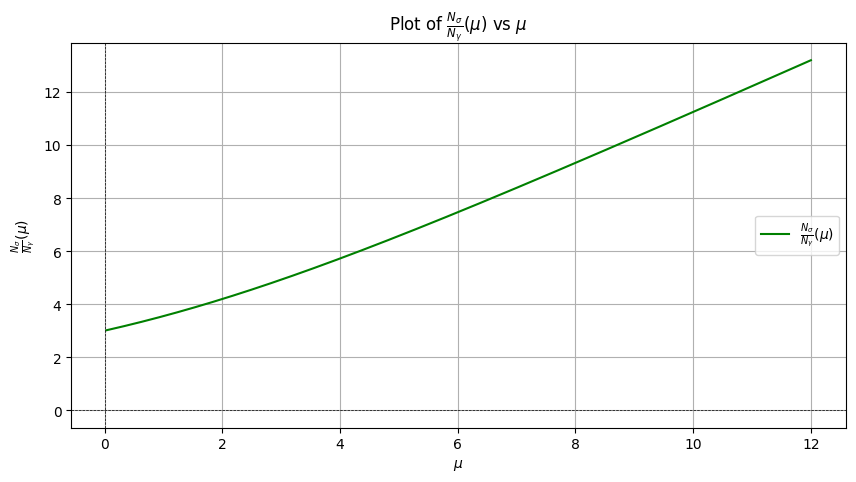

In [93]:
# Define the functions N_sigma(mu) and N_gamma(mu)
def N_sigma(mu):
    numerator = mu**2 * (1 + (mu - 1) * np.exp(mu))
    denominator = (1 - np.exp(mu))**2 - mu**2 * np.exp(mu)
    return numerator / denominator

def N_gamma(mu):
    numerator = mu * ((mu + 2) + (mu - 2) * np.exp(mu))
    denominator = (1 - np.exp(mu))**2 - mu**2 * np.exp(mu)
    return numerator / denominator

# Define the range for mu
mu_values = np.linspace(0, 12, 400)
# Avoid division by zero or invalid values in the denominator
mu_values = mu_values[~np.isclose((1 - np.exp(mu_values))**2 - mu_values**2 * np.exp(mu_values), 0)]

# Calculate N_sigma and N_gamma
N_sigma_values = N_sigma(mu_values)
N_gamma_values = N_gamma(mu_values)

# Plotting

# Plot for N_sigma(mu)
plt.figure(figsize=(10, 5))
plt.plot(mu_values, N_sigma_values, label=r'$N_\sigma(\mu)$', color='blue')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$N_\sigma(\mu)$')
plt.title(r'Plot of $N_\sigma(\mu)$ vs $\mu$')
plt.grid(True)
plt.legend()
plt.show()

# Plot for N_gamma(mu)
plt.figure(figsize=(10, 5))
plt.plot(mu_values, N_gamma_values, label=r'$N_\gamma(\mu)$', color='red')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$N_\gamma(\mu)$')
plt.title(r'Plot of $N_\gamma(\mu)$ vs $\mu$')
plt.grid(True)
plt.legend()
plt.show()

# Plot for N_sigma/N_gamma(mu)
plt.figure(figsize=(10, 5))
plt.plot(mu_values, N_sigma_values/N_gamma_values, label=r'$\frac{N_\sigma}{N_\gamma}(\mu)$', color='green')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\frac{N_\sigma}{N_\gamma}(\mu)$')
plt.title(r'Plot of $\frac{N_\sigma}{N_\gamma}(\mu)$ vs $\mu$')
plt.grid(True)
plt.legend()
plt.show()

In [94]:
rho = 1.225
V0 = 1000
Cd0 = 0.35
S = 0.0491
m = 100
g = 9.81
K = 0.08
r0 = 8000
sigma0 = 10
gamma0 = 10

sigma0 = np.deg2rad(sigma0)
gamma0 = np.deg2rad(gamma0)

print(sigma0,gamma0)


0.17453292519943295 0.17453292519943295


## Optimal Guidance Simulation with Impact Angle Constraint

This cell defines the full simulation of a missile's trajectory using optimal guidance laws, incorporating aerodynamic drag and a desired terminal impact angle.

### Key Components:

- **Guidance Functions**:
  - `N_sigma(μ)` and `N_gamma(μ)` compute feedback gains based on a non-dimensional parameter `μ`.

- **Sim Function**:
  - Simulates missile flight from initial conditions (`V0`, `sigma0`, `gamma0`, `r0`) toward a fixed target.
  - Includes effects of drag and dynamically computes acceleration commands (`a_cmd`) to satisfy the guidance law.
  - Continues until the missile is within 10 meters of the target.

- **Parameters**:
  - `rho`, `Cd0`, `S`, `m`, `K`: aerodynamic and mass properties.
  - `sigma0`, `gamma0`: initial LOS and flight path angles (in radians).
  - `gammad`: desired terminal impact angle (in radians).

- **Output**:
  - Arrays of position (`x`, `y`), range `r`, velocity `V`, time `t`, flight path `gamma`, LOS `sigma`, and acceleration `a`.

This simulation enables the evaluation of how the missile follows an optimal trajectory to strike the target at a specific angle, crucial in precision strike scenarios.


In [95]:
def N_sigma(mu):
    numerator = mu**2 * (1 + (mu - 1) * np.exp(mu))
    denominator = (1 - np.exp(mu))**2 - mu**2 * np.exp(mu)
    return numerator / denominator

def N_gamma(mu):
    numerator = mu * ((mu + 2) + (mu - 2) * np.exp(mu))
    denominator = (1 - np.exp(mu))**2 - mu**2 * np.exp(mu)
    return numerator / denominator


def Sim(rho,V0,Cd0,S,m,g,K,r0,sigma0,gamma0,gammad):
  x0,y0 = 0,0
  xt,yt = 8000,0
  i = 0
  x = np.zeros(1)
  y = np.zeros(1)
  t = np.zeros(1)
  a = np.zeros(1)
  gamma = np.array([gamma0])
  sigma = np.array([sigma0])
  r = np.array([r0])
  V = np.array([V0])
  k = rho*S*Cd0*0.5/(2*m)
  ki = 2*K*m/(rho*S)
  dt = 0.0001
  while(r[i]>1):
    mu = 4*k*r[i]
    a_cmd = -V[i]**2/r[i] * (N_sigma(mu)*(sigma[i]) + N_gamma(mu)*(gammad - gamma[i]))
    a[i] = a_cmd
    dr = -V[i]*np.cos(sigma[i])*dt
    dsigma = (a_cmd/V[i] + V[i]*np.sin(sigma[i])/r[i])*dt
    dgamma = a_cmd/V[i]*dt
    dV = -(k*V[i]**2+ ki*(a_cmd/V[i])**2)*dt
    r = np.append(r,r[i]+dr)
    V = np.append(V,V[i]+dV)
    sigma = np.append(sigma,sigma[i]+dsigma)
    gamma = np.append(gamma,gamma[i]+dgamma)
    t = np.append(t,t[i]+dt)
    x = np.append(x,r0-r[i] * np.cos(sigma[i]-gamma[i]))
    y = np.append(y,r[i] * np.sin(sigma[i]-gamma[i]))
    a=np.append(a,a_cmd)
    i=i+1
  return(x,y,r,t,V,gamma,sigma,a)


## Simulation of Optimal Guidance with Desired Impact Angles

This simulation evaluates missile guidance under varying desired impact angles using an optimal impact angle control law with aerodynamic drag. The following plots visualize key dynamics:

- **Trajectory Plot**: Shows the missile path for γ_d = -30° to -150°.
- **Velocity vs Time**: Depicts how speed changes under different guidance angles.
- **σ vs Time**: Evolution of line-of-sight angle.
- **γ vs Time**: Flight path angle convergence towards γ_d.
- **a vs Time**: Required control acceleration in g-units.

The results help in comparing the maneuvering behavior and control effort for different terminal attack angles.


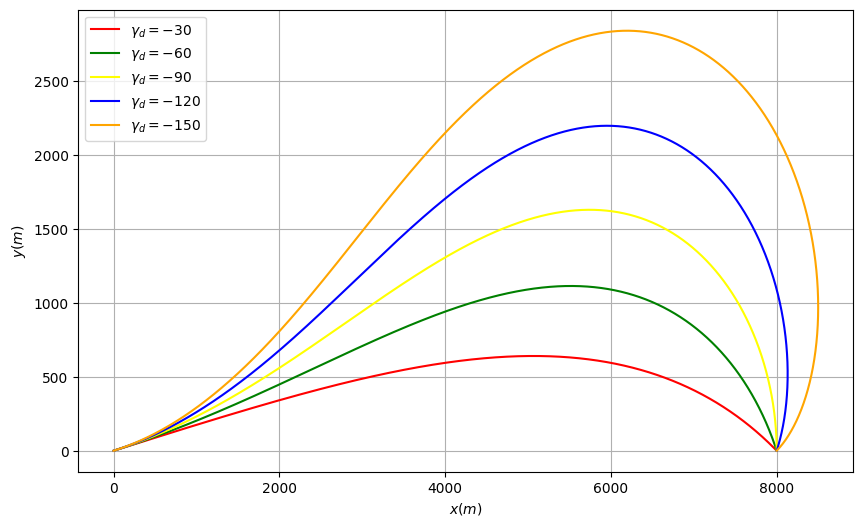

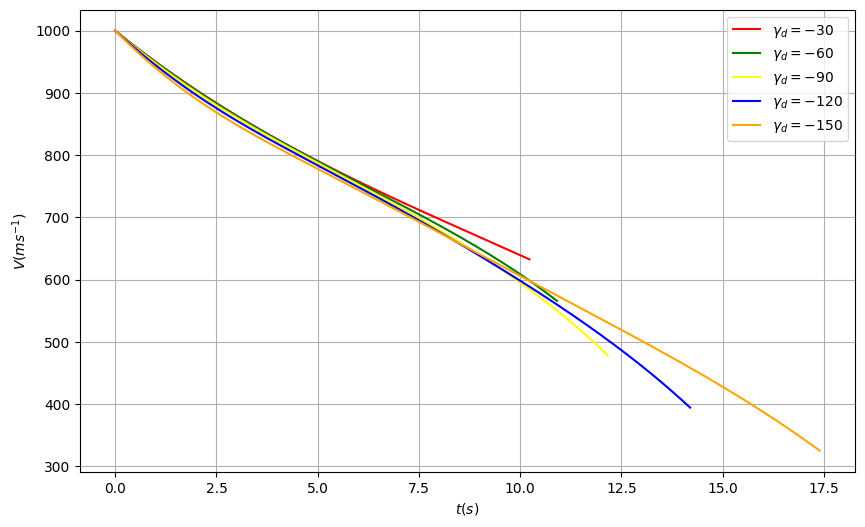

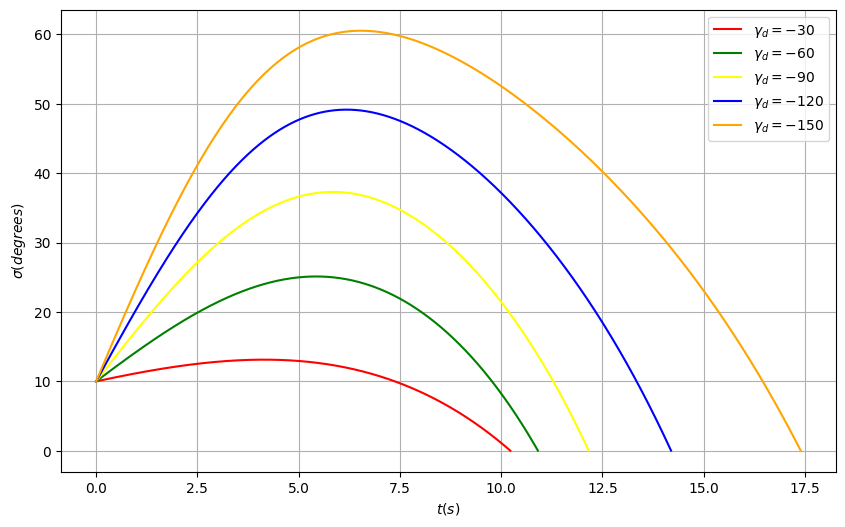

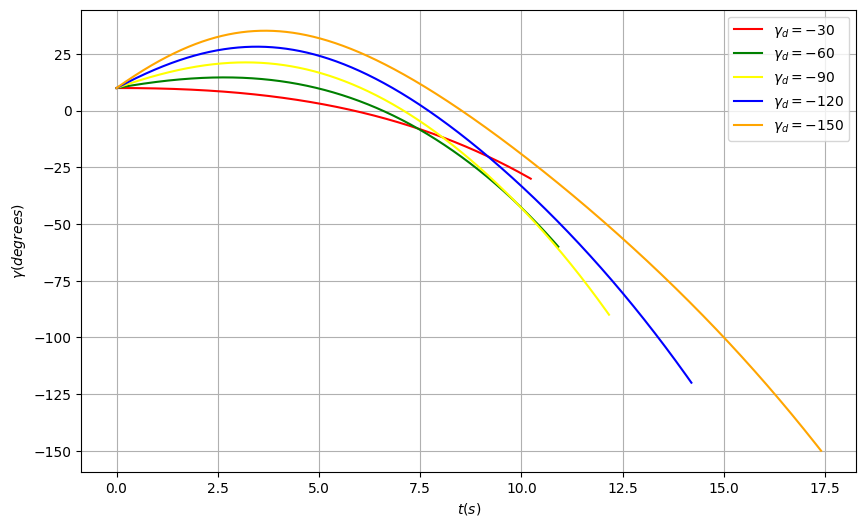

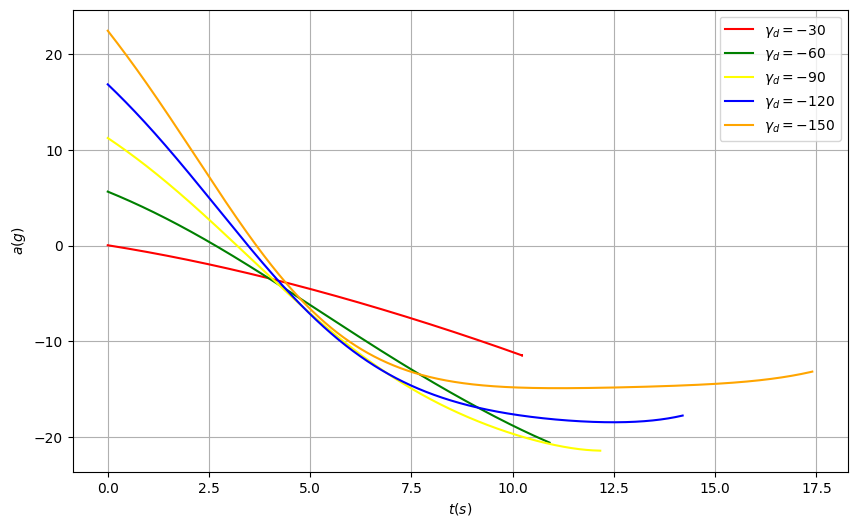

In [96]:
x_0,y_0,r_0,t_0,V_0,gamma_0,sigma_0,a_0 = Sim(rho,V0,Cd0,S,m,g,K,r0,sigma0,gamma0,np.deg2rad(-30))
x_1,y_1,r_1,t_1,V_1,gamma_1,sigma_1,a_1 = Sim(rho,V0,Cd0,S,m,g,K,r0,sigma0,gamma0,np.deg2rad(-60))
x_2,y_2,r_2,t_2,V_2,gamma_2,sigma_2,a_2 = Sim(rho,V0,Cd0,S,m,g,K,r0,sigma0,gamma0,np.deg2rad(-90))
x_3,y_3,r_3,t_3,V_3,gamma_3,sigma_3,a_3 = Sim(rho,V0,Cd0,S,m,g,K,r0,sigma0,gamma0,np.deg2rad(-120))
x_4,y_4,r_4,t_4,V_4,gamma_4,sigma_4,a_4 = Sim(rho,V0,Cd0,S,m,g,K,r0,sigma0,gamma0,np.deg2rad(-150))

plt.figure(figsize=(10,6))
plt.plot(x_0,y_0,label=r'$\gamma_d=-30$',color = "red")
plt.plot(x_1,y_1,label=r'$\gamma_d=-60$',color = "green")
plt.plot(x_2,y_2,label=r'$\gamma_d=-90$',color = "yellow")
plt.plot(x_3,y_3,label=r'$\gamma_d=-120$',color = "blue")
plt.plot(x_4,y_4,label=r'$\gamma_d=-150$',color = "orange")
plt.grid()
plt.legend()
plt.xlabel(r'$x(m)$')
plt.ylabel(r'$y(m)$')
plt.show()

plt.figure(figsize=(10,6))
plt.plot(t_0,V_0,label=r'$\gamma_d=-30$',color = "red")
plt.plot(t_1,V_1,label=r'$\gamma_d=-60$',color = "green")
plt.plot(t_2,V_2,label=r'$\gamma_d=-90$',color = "yellow")
plt.plot(t_3,V_3,label=r'$\gamma_d=-120$',color = "blue")
plt.plot(t_4,V_4,label=r'$\gamma_d=-150$',color = "orange")
plt.grid()
plt.legend()
plt.xlabel(r'$t(s)$')
plt.ylabel(r'$V (ms^{-1})$')
plt.show()

plt.figure(figsize=(10,6))
plt.plot(t_0,sigma_0*57.2957795131,label=r'$\gamma_d=-30$',color = "red")
plt.plot(t_1,sigma_1*57.2957795131,label=r'$\gamma_d=-60$',color = "green")
plt.plot(t_2,sigma_2*57.2957795131,label=r'$\gamma_d=-90$',color = "yellow")
plt.plot(t_3,sigma_3*57.2957795131,label=r'$\gamma_d=-120$',color = "blue")
plt.plot(t_4,sigma_4*57.2957795131,label=r'$\gamma_d=-150$',color = "orange")
plt.grid()
plt.legend()
plt.xlabel(r'$t(s)$')
plt.ylabel(r'$\sigma (degrees)$')
plt.show()

plt.figure(figsize=(10,6))
plt.plot(t_0,gamma_0*57.2957795131,label=r'$\gamma_d=-30$',color = "red")
plt.plot(t_1,gamma_1*57.2957795131,label=r'$\gamma_d=-60$',color = "green")
plt.plot(t_2,gamma_2*57.2957795131,label=r'$\gamma_d=-90$',color = "yellow")
plt.plot(t_3,gamma_3*57.2957795131,label=r'$\gamma_d=-120$',color = "blue")
plt.plot(t_4,gamma_4*57.2957795131,label=r'$\gamma_d=-150$',color = "orange")
plt.grid()
plt.legend()
plt.xlabel(r'$t(s)$')
plt.ylabel(r'$\gamma (degrees)$')
plt.show()

plt.figure(figsize=(10,6))
plt.plot(t_0,a_0/g,label=r'$\gamma_d=-30$',color = "red")
plt.plot(t_1,a_1/g,label=r'$\gamma_d=-60$',color = "green")
plt.plot(t_2,a_2/g,label=r'$\gamma_d=-90$',color = "yellow")
plt.plot(t_3,a_3/g,label=r'$\gamma_d=-120$',color = "blue")
plt.plot(t_4,a_4/g,label=r'$\gamma_d=-150$',color = "orange")
plt.grid()
plt.legend()
plt.xlabel(r'$t(s)$')
plt.ylabel(r'$a (g)$')
plt.show()




## Time Evolution of Position Components

These plots show how the missile’s horizontal and vertical positions evolve over time for various desired impact angles:

- **x vs Time**: Displays the longitudinal distance covered by the missile.
- **y vs Time**: Shows the altitude variation during flight.

This analysis highlights how different terminal angle requirements affect the missile’s spatial path over time.

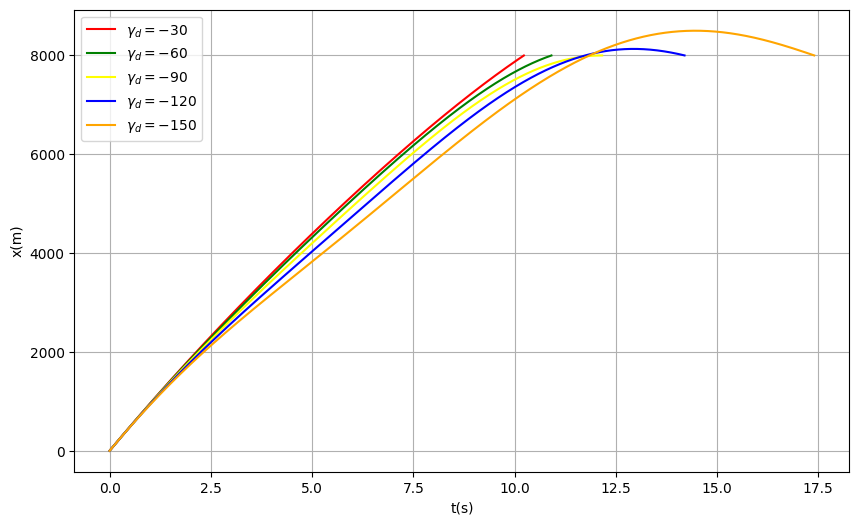

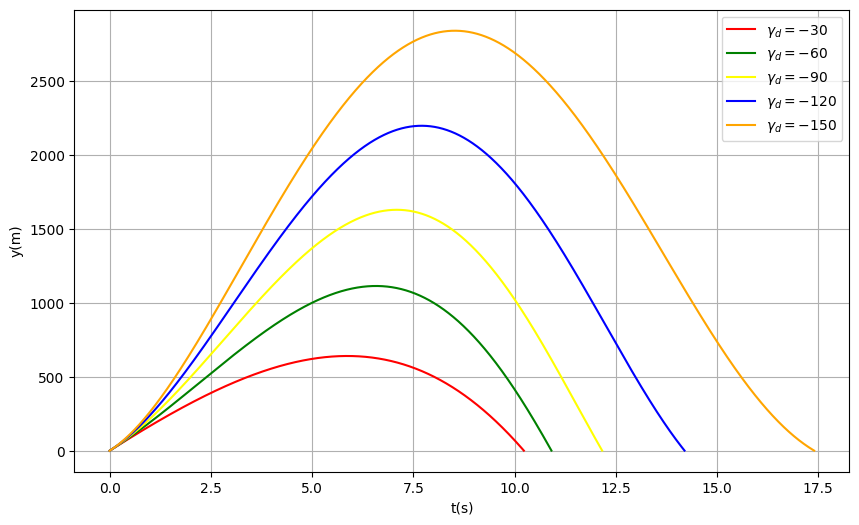

In [97]:
plt.figure(figsize=(10,6))
plt.plot(t_0,x_0,label=r'$\gamma_d=-30$',color = "red")
plt.plot(t_1,x_1,label=r'$\gamma_d=-60$',color = "green")
plt.plot(t_2,x_2,label=r'$\gamma_d=-90$',color = "yellow")
plt.plot(t_3,x_3,label=r'$\gamma_d=-120$',color = "blue")
plt.plot(t_4,x_4,label=r'$\gamma_d=-150$',color = "orange")
plt.grid()
plt.legend()
plt.xlabel("t(s)")
plt.ylabel("x(m)")
plt.show()

plt.figure(figsize=(10,6))
plt.plot(t_0,y_0,label=r'$\gamma_d=-30$',color = "red")
plt.plot(t_1,y_1,label=r'$\gamma_d=-60$',color = "green")
plt.plot(t_2,y_2,label=r'$\gamma_d=-90$',color = "yellow")
plt.plot(t_3,y_3,label=r'$\gamma_d=-120$',color = "blue")
plt.plot(t_4,y_4,label=r'$\gamma_d=-150$',color = "orange")
plt.grid()
plt.legend()
plt.xlabel("t(s)")
plt.ylabel("y(m)")
plt.show()